# FIT3182 - Big data management and processing

Name: Cheong Karr Kei

Student ID: 30091497

Email: kche0070@student.monash.edu

# Assignment Part B #

**Task 2. Data Visualisation**



**1. Streaming data Visualisation**

a. Line graph of air temperature against arrival time for incoming climate data


In [ ]:
# import statements
from kafka import KafkaConsumer
import datetime as dt
from json import loads
import statistics
import matplotlib.pyplot as plt
import statistics

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'FIT3182_Assignment'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, \n Air temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, \n Air temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   # consumer_timeout_ms=100000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['127.0.0.1:9092'],
                                   value_deserializer=lambda x: loads(x.decode('ascii')),
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        #set width
        width = 9.5
        #set height
        height = 6
        #create new figure
        fig = plt.figure(figsize=(width,height)) 
        #adding the subplot axes to the given grid position
        ax = fig.add_subplot(111) 
        #set title
        fig.suptitle('Real-time climate stream data visualization') 
        #set x label
        ax.set_xlabel('Arrival time')
        #set y label
        ax.set_ylabel('Air temperature')
        #set y ticks
        ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
        #displaying the figure
        fig.show() 
        #drawing on the canvas
        fig.canvas.draw() 
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            #get keys
            key = str(message.key.decode('utf-8'))
            
            if key == "P1":
            
                #get climate data
                data = message.value
                #print(data)
                #add arrival time to x
                x.append(dt.datetime.now().strftime("%X"))
                #print(x)
                #add air temperature to y
                y.append(data["air_temperature_celcius"]) 
                #print(y)
            
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival time')
                ax.set_ylabel('Air temperature')
                ax.set_yticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                #removing the item in the first position
                x.pop(0) 
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)
    
    

**2. Static data Visualisation**

a. Bar chart to visualise the total number of fire records based on each hour 


In [1]:
from pymongo import MongoClient
from pprint import pprint
import matplotlib.pyplot as plt
import datetime as dt


client = MongoClient()
#Get DB
db = client.fit3182_assignment_db
#Get fire collection
fire = db.fire_stream_test
#New fire collection to duplicate fire stream 
fire_2 = db.fire_stream_2
#Clear collection
fire_2.drop()

results = fire.find()

for result in results:
    #add hour field
    result["hour"] = int(dt.datetime.strptime(result["datetime"],"%Y-%m-%dT%H:%M:%S").strftime("%H"))
    fire_2.insert_one(result)
    
results = fire_2.find()
    
#array to store hours
hours = []
#array to store corresponding counts
counts = []

#perform aggregation to get total fires for each hour
results = fire_2.aggregate([
   {"$group" : { "_id" : "$hour", "count" : {"$sum" : 1}}},
    { "$project": {  
      "_id": 0,
      "hour": "$_id",
      "count": 1
   }
}
])

#add to arrays
for document in results:
    hours.append(document["hour"])
    counts.append(document["count"])
    pprint(document)


{'count': 12, 'hour': 14}
{'count': 6, 'hour': 11}
{'count': 20, 'hour': 16}
{'count': 16, 'hour': 20}
{'count': 20, 'hour': 9}
{'count': 10, 'hour': 4}
{'count': 14, 'hour': 19}
{'count': 19, 'hour': 7}
{'count': 12, 'hour': 12}
{'count': 17, 'hour': 21}
{'count': 14, 'hour': 1}
{'count': 11, 'hour': 18}
{'count': 11, 'hour': 10}
{'count': 15, 'hour': 2}
{'count': 24, 'hour': 15}
{'count': 12, 'hour': 17}
{'count': 10, 'hour': 8}
{'count': 13, 'hour': 0}
{'count': 9, 'hour': 6}
{'count': 17, 'hour': 13}
{'count': 10, 'hour': 23}
{'count': 13, 'hour': 3}
{'count': 13, 'hour': 22}
{'count': 16, 'hour': 5}


<BarContainer object of 24 artists>

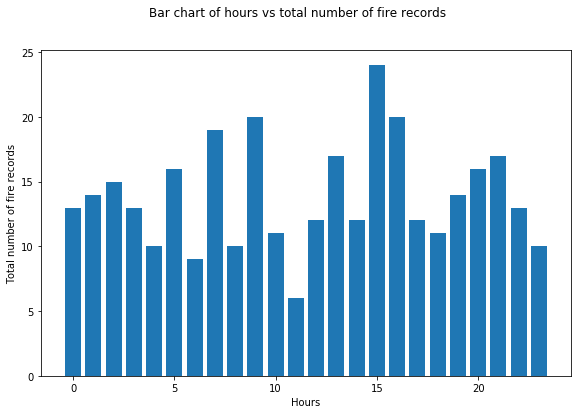

In [2]:
import matplotlib.pyplot as plt

#set width
width = 9.5
#set height
height = 6
#create figure
fig = plt.figure(figsize=(width,height)) 
ax = fig.add_subplot(111) 
#set title
fig.suptitle('Bar chart of hours vs total number of fire records') 
#set x label
ax.set_xlabel('Hours')
#set y label
ax.set_ylabel('Total number of fire records')

#plot bar chart
ax.bar(hours,counts)




**2. Static data Visualisation**

b. Map to visualise the fire locations

In [3]:
from pymongo import MongoClient
from pprint import pprint
import matplotlib.pyplot as plt
import datetime as dt
import folium

#Create map with initial location in Victoria
m = folium.Map(location=[-37.4713,144.7852])


client = MongoClient()
#Get DB
db = client.fit3182_assignment_db
#Get fire collection
fire = db.fire_stream 
#Get climate collection
climate = db.climate_stream


results = fire.find()

for result in results:
    #get surface temperature 
    surface_temp = result["surface_temperature_celcius"]
    #get confidence 
    confidence = result["confidence"]
    #get latitude 
    lat = result["latitude"]
    #get longitude
    long = result["longitude"]
    #get cause
    cause = result["cause"]
    
    #get corresponding climate data 
    fire_date  = result["date"]
    climate_results = climate.find({"date":fire_date})
    climate_data = None
    for climate_result in climate_results:
        climate_data = climate_result
    #get relative humidity
    rel_humid = climate_data["relative_humidity"]
    #get air temperature
    air_temp = climate_data["air_temperature_celcius"]
    
    #set tooltip
    tooltip = "<b>Air Temp:</b> "+ str(air_temp) +"<br><b>Surface Temp:</b> " + str(surface_temp) + "<br><b>Confidence:</b> " + str(confidence) + "<br><b>Relative humidity:</b> " + str(rel_humid) 
    
    #set colour of marker, if cause is "natural" then blue, if cause is "other" then red
    marker_col = None
    if cause == "other":
        marker_col = "red"
    elif cause == "natural":
        marker_col = "blue"
        
    #add marker
    folium.Marker(
        [lat, long],
        tooltip=tooltip,
        icon=folium.Icon(color=marker_col)
    ).add_to(m)
    
    
#show map
m

